## Learning from Data Week 7

In [81]:
from __future__ import division
%matplotlib inline
import pandas as pd
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

In [2]:
train = pd.read_table("in.dta", sep=" +", header=None, engine='python')
train.columns = ["x1", "x2", "y"]
test = pd.read_table("out.dta", sep=" +", header=None, engine='python')
test.columns = ["x1", "x2", "y"]

In [4]:
train.head()

,x1,x2,y
0,-0.779470,0.838221,1
1,0.155635,0.895377,1
2,-0.059908,-0.717780,1
3,0.207596,0.758933,1
4,-0.195983,-0.375487,-1


In [5]:
for df in [train, test]:
    df['one'] = 1
    df['x1^2'] = df['x1']**2
    df['x2^2'] = df['x2']**2
    df['x1x2'] = df['x1']*df['x2']
    df['|x1-x2|'] = np.abs(df['x1'] - df['x2'])
    df['|x1+x2|'] = np.abs(df['x1'] + df['x2'])

In [6]:
train = train.reindex(columns = ['one', 'x1', 'x2', 'x1^2', 'x2^2', 'x1x2', '|x1-x2|', '|x1+x2|', 'y'])
test = test.reindex(columns = ['one', 'x1', 'x2', 'x1^2', 'x2^2', 'x1x2', '|x1-x2|', '|x1+x2|', 'y'])

In [7]:
train.head()

,one,x1,x2,x1^2,x2^2,x1x2,|x1-x2|,|x1+x2|,y
0,1,-0.779470,0.838221,0.607574,0.702615,-0.653369,1.617692,0.058751,1
1,1,0.155635,0.895377,0.024222,0.801701,0.139352,0.739743,1.051012,1
2,1,-0.059908,-0.717780,0.003589,0.515208,0.043001,0.657872,0.777688,1
3,1,0.207596,0.758933,0.043096,0.575980,0.157552,0.551337,0.966530,1
4,1,-0.195983,-0.375487,0.038409,0.140991,0.073589,0.179504,0.571470,-1


### Problem 1

In [30]:
def LR_validation(train_set, val_set):
    ks = range(3,8)
    errors = []
    for k in ks:
        # Calculate weights
        w = np.dot(np.linalg.pinv(train_set.ix[:, :k+1]), train_set['y'])
        # Predict and evaluate on validation set
        y_est = np.sign(np.dot(val_set.ix[:, :k+1], w))
        error = np.mean(y_est != val_set['y'])
        errors.append(error)
    best_k = ks[np.argmin(errors)]
    print zip(ks, errors)
    print "Best k: {}".format(best_k)

LR_validation(train[:25], train[25:])

[(3, 0.29999999999999999), (4, 0.5), (5, 0.20000000000000001), (6, 0.0), (7, 0.10000000000000001)]
Best k: 6


k = 6 (6 parameters) performed the best.

### Problem 2

In [32]:
# Evaluate on TEST set
LR_validation(train[:25], test)

[(3, 0.41999999999999998), (4, 0.41599999999999998), (5, 0.188), (6, 0.084000000000000005), (7, 0.071999999999999995)]
Best k: 7


### Problem 3

In [34]:
# Reverse train/validation order
LR_validation(train[25:], train[:25])

[(3, 0.28000000000000003), (4, 0.35999999999999999), (5, 0.20000000000000001), (6, 0.080000000000000002), (7, 0.12)]
Best k: 6


### Problem 4

In [36]:
# Reverse train/validation order and evaluate on TEST set
LR_validation(train[25:], test)

[(3, 0.39600000000000002), (4, 0.38800000000000001), (5, 0.28399999999999997), (6, 0.192), (7, 0.19600000000000001)]
Best k: 6


### Problem 6

(0.50210042420517842, 0.49932306134428783, 0.33392841354727337)


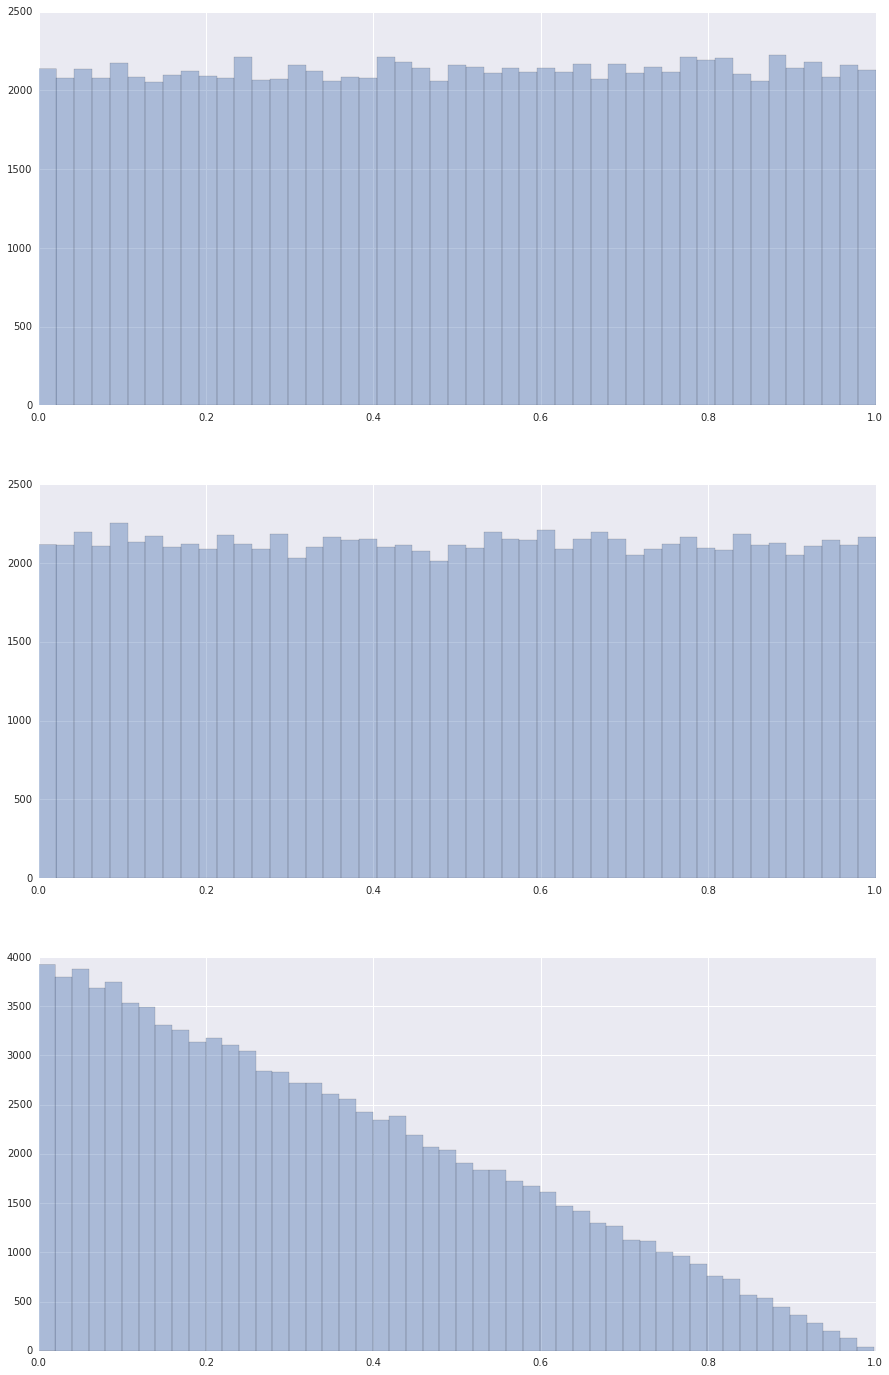

In [50]:
# Validation bias
def validation_bias():
    e_1, e_2 = np.random.uniform(size=100000), np.random.uniform(size=100000)
    e_min = np.minimum(e_1, e_2)
    print (np.mean(e_1), np.mean(e_2), np.mean(e_min))
    
    # Plot figures
    plt.figure(figsize=(15,24))
    for i, v in enumerate([e_1, e_2, e_min]):
        plt.subplot(3, 1, i+1)
        sns.distplot(v, kde=False)
        
validation_bias()

### Problem 8: PLA & SVM

In [104]:
def generate_points(N):
    """Generate random points on the interval [-1,1] x [-1,1]."""
    xs = np.random.uniform(-1,1,N)
    ys = np.random.uniform(-1,1,N)
    # Generate vector of ones in the 0th column
    return np.column_stack((np.ones(N), xs, ys))

generate_points(5)

array([[ 1.        ,  0.76456734,  0.77811991],
       [ 1.        ,  0.46657827,  0.47455716],
       [ 1.        , -0.18054759, -0.98969407],
       [ 1.        , -0.25297797,  0.3883157 ],
       [ 1.        ,  0.03127669,  0.83901481]])

In [176]:
def assignment(points):
    """Create target function f and assign labels to points."""
    # Generate f until all points have different labels
    while True:
        # Randomly select 2 2-D points and 1 direction
        (x1, y1, x2, y2, direction) = np.random.uniform(-1,1,5)
        # Calculate weight vector and assign labels
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m*x1
        w = [b, m * np.sign(direction), -1*np.sign(direction)]
        labels = np.sign(np.dot(points, w))
        # Re-do points if all labels are equal
        if abs(sum(labels)) != len(points): break
    return (w, labels)

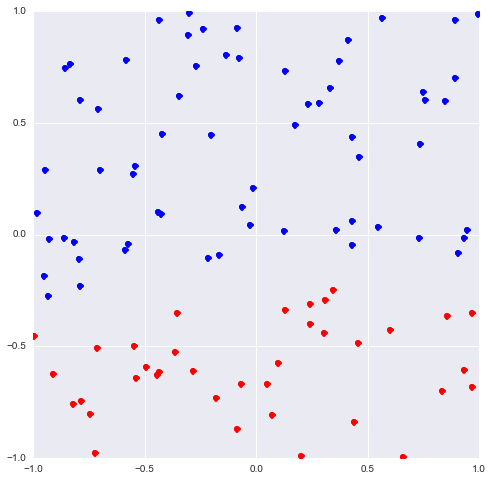

In [180]:
def show_labels(points, labels):
    # Plot of points with labels
    plt.figure(figsize = (8,8))
    plt.plot(points[labels == 1][:,1], points[labels == 1][:,2], 'bo')
    plt.plot(points[labels == -1][:,1], points[labels == -1][:,2], 'ro')

# Pick random points and produce plot
random_points = generate_points(100)
_ , random_labels = assignment(random_points)
show_labels(random_points, random_labels)

In [65]:
def probs(w, w_est):
    """Calculate out of sample error given the target f and hypothesis g."""
    # Create grid of points
    NUM_POINTS = 100
    x, y = np.linspace(-1, 1, NUM_POINTS), np.linspace(-1, 1, NUM_POINTS)
    xv, yv = np.meshgrid(x, y)
    grid = np.column_stack((np.ones(NUM_POINTS**2), xv.flatten(), yv.flatten()))
    # Calculate actual and predicted labels
    actual_labels = np.sign(np.dot(grid, w))
    predicted_labels = np.sign(np.dot(grid, w_est))
    # Calculate probability of nonoverlap
    return np.mean(actual_labels != predicted_labels)

In [63]:
def PLA(points, labels):
    """Run PLA on input training data and return weights"""
    # Initialize weights and accuracy
    w_est = np.array([0, 0, 0])
    accuracy = 0
    
    # Iterate to improve weights
    while accuracy < 1:
        # Make and evaluate predictions
        preds = np.sign(np.dot(points, w_est))
        misclassified = preds != labels
        misclassified_points = points[misclassified]
        misclassified_labels = labels[misclassified]
        
        # Measure accuracy of current iteration
        accuracy = np.mean(~misclassified)
        
        # Randomly pick one misclassified point and update weight
        if accuracy < 1:
            random_point = np.random.randint(misclassified_points.shape[0])
            w_est = w_est + misclassified_labels[random_point] * misclassified_points[random_point]
    return w_est

In [140]:
# Suppress QP printing
cvxopt.solvers.options['show_progress'] = False

In [143]:
def SVM(points, labels):
    # Remove column of ones
    points = points[:, 1:]
    # Calculate quadratic coefficients
    N = len(labels)
    yi_xi = labels[:, None] * points
    coefs_quadratic = np.dot(yi_xi, yi_xi.T)
    coefs_linear = np.array([-1.0] * N)
    # Quadratic programming using CVXOPT
    P = cvxopt.matrix(coefs_quadratic, tc="d")
    q = cvxopt.matrix(coefs_linear, tc="d")
    G = cvxopt.matrix(-np.eye(N), tc="d")
    h = cvxopt.matrix(np.zeros(N), tc="d")
    A = cvxopt.matrix(labels, (1,N), tc="d")
    b = cvxopt.matrix(0.0)
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    # Calculate weights
    solution_x = np.ravel(solution['x'])
    w_est = np.dot(solution_x, labels[:, None] * points)
    # Calculate threshold(b) using the first support vector (could use any)
    support_vectors = np.where(solution_x >= 0.0001)[0]    
    b = 1/labels[support_vectors[0]] - np.dot(w_est, points[support_vectors[0]])
    return w_est, b, support_vectors

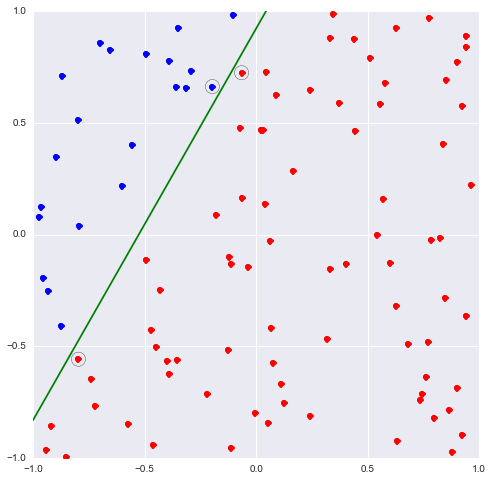

In [188]:
def SVM_plot():
    points = generate_points(100)
    w, labels = assignment(points)
    w_est, b, support_vectors = SVM(points, labels)
    # Show labels
    show_labels(points, labels)
    # Draw SVM line
    x = np.linspace(-1, 1, 10)
    y = -(w_est[0]*x + b)/w_est[1]
    plt.plot(x, y, 'g-')
    # Highlight support vectors
    plt.scatter(points[support_vectors][:,1], points[support_vectors][:,2], 
                s=200, facecolors='none', edgecolors='black')
    plt.axis([-1, 1, -1, 1])
    
SVM_plot()

In [182]:
def problem_8(N, RUNS):
    SVM_over_PLA = []
    for run in range(RUNS):
        points = generate_points(N)
        w, labels = assignment(points)
        # PLA
        w_est_PLA = PLA(points, labels)
        total_probs_PLA = probs(w, w_est_PLA)
        # SVM
        w_est_SVM, b, support_vectors = SVM(points, labels)
        total_probs_SVM = probs(w, np.concatenate((np.array([b]), w_est_SVM)))
        # Compare PLA and SVM
        SVM_over_PLA.append(total_probs_SVM < total_probs_PLA)
    print ("SVM is better than PLA in % of runs: {}".format(np.mean(SVM_over_PLA)))
    print ("The average number of support vectors: {}".format(len(support_vectors)))
    
problem_8(10, 1000)

SVM is better than PLA in % of runs: 0.608
The average number of support vectors: 3


In [183]:
problem_8(100, 1000)

SVM is better than PLA in % of runs: 0.628
The average number of support vectors: 3
